In [83]:
import io
import random
import json
import csv
import os.path as osp
import ase
from ase.io import read as ase_read
import ase.io
import numpy as np
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch_geometric.data import Data, Dataset, InMemoryDataset
from mp_api.client import MPRester
from torch_geometric.utils import dense_to_sparse, add_self_loops
from torch.utils.data import random_split, Subset
from typing import Sequence
from itertools import permutations

from model import load_model
import copy

from args import *
from utils import *

1782.348676412832 4490 0.3969596161275795 tensor(-0.1000)
4490 4490
negative formation energy ratio: 0.5182628062360802
MAE=  0.3969596164838031
tensor([[-0.1059],
        [-0.1405],
        [-0.0510],
        ...,
        [-0.0771],
        [-0.1453],
        [-0.1227]]) tensor([-0.3218, -0.0684,  0.3549,  ...,  0.0567,  0.1481, -0.1327])


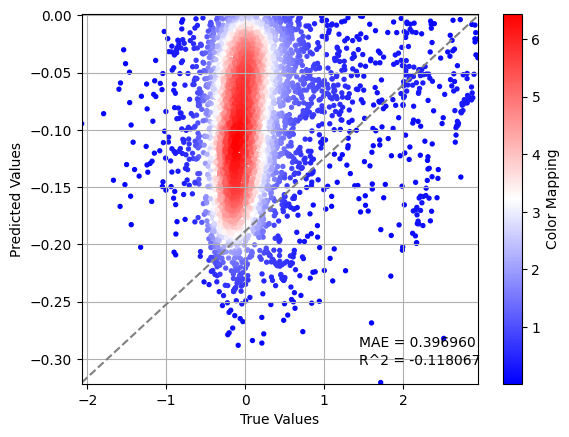

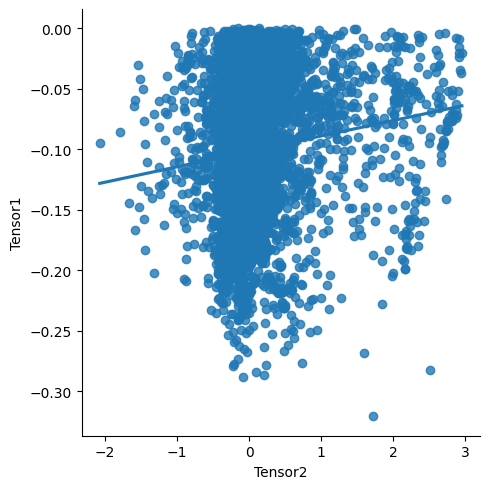

In [95]:
DATASET_1G = "1G_DFT_dataset/"
FORMATION_ENERGY_NAME = "FORMATION_ENERGY_"
MATERIAL_NAME = "POSCAR_"
TOTAL_DATASET_NUM = 4542

SAMPLE_DATA_PATH = "results/CEAL/1717473742365643/sample_data.pt"

sample_data = torch.load(SAMPLE_DATA_PATH)

res_pred_list = torch.zeros(0)
res_DFT_list = torch.zeros(0)


MAE = 0.0
total = 0
for i in range(1, TOTAL_DATASET_NUM + 1):
    res_DFT_data_path = osp.join(DATASET_1G, FORMATION_ENERGY_NAME + str(i))
    material_data_path = osp.join(DATASET_1G, MATERIAL_NAME + str(i))

    exist = False
    if osp.exists(res_DFT_data_path):
        with open(res_DFT_data_path, "r") as file:
            res_DFT = file.readline()
        try:
            res_DFT = torch.Tensor([float(res_DFT)])
            exist = True
        except:
            print(res_DFT_data_path)
        file.close()

    if osp.exists(material_data_path) and exist:
        res_pred = torch.Tensor([sample_data["pred_list"][i - 1]])

        out_range = torch.abs(res_pred - res_DFT) > 3
        if out_range.item():
            continue
        total += 1
        res_pred_list = torch.cat((res_pred_list, res_pred), 0)
        res_DFT_list = torch.cat((res_DFT_list, res_DFT), 0)

        abs_error = torch.abs(torch.subtract(res_DFT, res_pred)).item()
        # print(res_DFT, res_pred, abs_error)
        MAE = MAE + abs_error
        # print(i, MAE, abs_error, res_DFT, res_pred)  # 1847

    # if osp.exists(material_data_path) is False:
    #     print(material_data_path)

    # if osp.exists(res_DFT_data_path) is False:
    #     print(res_DFT_data_path)


print(MAE, total, MAE / total)
print(len(res_pred_list), len(res_DFT_list))

print("negative formation energy ratio:", len(res_DFT_list[res_DFT_list < 0.0]) / total)
save_regression_result(res_pred_list, res_DFT_list, ".")
plot_regression_result("", ".")

print(res_pred_list, res_DFT_list)


# 将 tensor 转换为 numpy 数组
array1 = res_pred_list.numpy().flatten()
array2 = res_DFT_list.numpy()

# 创建一个 DataFrame
data = pd.DataFrame({"Tensor1": array1, "Tensor2": array2})

# 使用 Seaborn 的 lmplot 绘制线性回归图
sns.lmplot(x="Tensor2", y="Tensor1", data=data, ci=None)

# 显示图表
plt.show()

In [66]:
# Get all predict data
sample_data
# print(len(sample_data["pred_list"]))

{'data_list': [Data(edge_index=[2, 192], edge_attr=[192, 1], x=[16, 100], id=1704),
  Data(edge_index=[2, 222], edge_attr=[222, 1], x=[22, 100], id=2580),
  Data(edge_index=[2, 407], edge_attr=[407, 1], x=[83, 100], id=3047),
  Data(edge_index=[2, 467], edge_attr=[467, 1], x=[95, 100], id=3093),
  Data(edge_index=[2, 846], edge_attr=[846, 1], x=[82, 100], id=3160),
  Data(edge_index=[2, 146], edge_attr=[146, 1], x=[42, 100], id=3521),
  Data(edge_index=[2, 544], edge_attr=[544, 1], x=[72, 100], id=3583),
  Data(edge_index=[2, 392], edge_attr=[392, 1], x=[56, 100], id=4357),
  Data(edge_index=[2, 264], edge_attr=[264, 1], x=[40, 100], id=4581),
  Data(edge_index=[2, 23], edge_attr=[23, 1], x=[5, 100], id=4672),
  Data(edge_index=[2, 70], edge_attr=[70, 1], x=[10, 100], id=4684),
  Data(edge_index=[2, 68], edge_attr=[68, 1], x=[10, 100], id=4708),
  Data(edge_index=[2, 32], edge_attr=[32, 1], x=[8, 100], id=5063),
  Data(edge_index=[2, 150], edge_attr=[150, 1], x=[22, 100], id=5122),
  D